In [6]:
import numpy as np
import torch
import largestinteriorrectangle as lir
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator

In [7]:
USE_DEPTHMAP = True  # True: use depthmap, False: automatically detect

# Define paths to SAM checkpoints,
# "sam_vit_b" is the base model,
# "sam_vit_l" is the large model,
# "sam_vit_h" is the huge model,
# read README.md in folder /SAM for more information
RUNTIME_ENV = "colab"  # "colab" or "local"
SAM_CKPT_B = "sam_vit_b_01ec64.pth" if RUNTIME_ENV == "colab" else "sam/sam_vit_b_01ec64.pth"
SAM_CKPT_L = "sam_vit_l_0b3195.pth" if RUNTIME_ENV == "colab" else "sam/sam_vit_l_0b3195.pth"
SAM_CKPT_H = "sam_vit_h_4b8939.pth" if RUNTIME_ENV == "colab" else "sam/sam_vit_h_4b8939.pth"

# Select SAM model type
MODEL_TYPE = "vit_h"
MODEL_WEIGHTS = SAM_CKPT_H

# Set target ratio of black area in binarized images
TARGET_RATIO = 60

In [9]:
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator

In [11]:
import os

download_link = {
    SAM_CKPT_B: "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth",
    SAM_CKPT_L: "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth",
    SAM_CKPT_H: "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth",
}

if not os.path.exists(MODEL_WEIGHTS):
  !wget {download_link[MODEL_WEIGHTS]} -O {MODEL_WEIGHTS}
  
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load SAM model
SAM = sam_model_registry[MODEL_TYPE](checkpoint=MODEL_WEIGHTS)
SAM.to(device=DEVICE)

# Select SAM predictor
PREDICTOR = SamPredictor(SAM) if USE_DEPTHMAP else SamAutomaticMaskGenerator(SAM)

--2024-06-17 14:40:01--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 2600:9000:20a7:6200:13:6e38:acc0:93a1, 2600:9000:20a7:1800:13:6e38:acc0:93a1, 2600:9000:20a7:0:13:6e38:acc0:93a1, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|2600:9000:20a7:6200:13:6e38:acc0:93a1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: 'sam_vit_h_4b8939.pth'

     0K .......... .......... .......... .......... ..........  0%  908K 45m58s
    50K .......... .......... .......... .......... ..........  0%  933K 45m21s
   100K .......... .......... .......... .......... ..........  0% 19.0M 30m57s
   150K .......... .......... .......... .......... ..........  0% 1012K 33m31s
   200K .......... .......... .......... .......... ..........  0% 6.41M 28m5s
   250K .......... .......... .......... .......... ..........  0% 1.17M 29m14s

## Function

In [13]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

## Generate Segmentation with Bounding Box

In [23]:
import cv2
import numpy as np
import supervision as sv


mask_predictor = SamPredictor(SAM)

In [31]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [32]:
import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread('recording_room.jpg')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

SupervisionWarnings: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.22.0`. Use `Color.RED` instead.
SupervisionWarnings: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.22.0`. Use `Color.RED` instead.
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


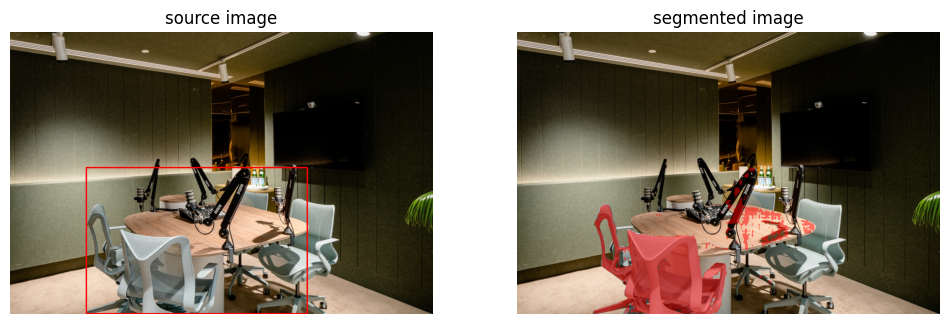

In [33]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)